In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import seaborn as sn
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
import sqlite3

In [2]:
con=sqlite3.connect('database.sqlite')
dataBase=pd.read_sql_query("""
Select *
from Reviews
where Score !=3
""", con)

In [3]:
def change(n):
    if n>3:
        return 1
    else:
        return 0

Score=dataBase['Score']
Reviews=Score.map(change)

In [4]:
dataBase['Score']=Reviews

In [5]:
Database=dataBase.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

In [6]:
Database=Database[Database.HelpfulnessNumerator <= Database.HelpfulnessDenominator]

In [7]:
SortedDatabase= Database.sort_values(by=['Time'], ascending=True,)

In [25]:
SortedDatabase=SortedDatabase.head(50000)

In [26]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop=set(stopwords.words("english"))#case-sensitive
sno=nltk.stem.SnowballStemmer('english') #initializing snowball stemmer
def cleantags(sen):
    clean=re.compile('<.*?>')
    cleaned=re.sub(clean,'',sen)
    return cleaned
def cleanpunctuations(sen):
    cleann=re.sub(r'[?|!|\'|"|#]',r'',sen)
    cleann=re.sub(r'[,|.|)|(|\|/]',r'',cleann)
    return cleann

In [27]:
i=0
strin=''
positive=[]
negative=[]
finalstring=[]
s=''
for sent in SortedDatabase['Text'].values:
    filtered_sentences=[]
    sent=cleantags(sent)
    for a in sent.split():
        for cleaned_words in cleanpunctuations(a).split():
            if((cleaned_words.isalpha())& (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentences.append(s)
                    if(SortedDatabase['Score'].values)[i]==1:
                        positive.append(s) #list of all words used
                    if(SortedDatabase['Score'].values)[i]==0:
                        negative.append(s)
                else:
                    continue
            else:
                continue
    strin = b" ".join(filtered_sentences) 
    finalstring.append(strin)
    i+=1

In [28]:
SortedDatabase['CleanText']=finalstring

In [29]:
X=SortedDatabase['CleanText']
Y=SortedDatabase['Score']

In [30]:
X.shape

(30000,)

# BAG OF WORDS APPROACH

In [31]:
count_vect = CountVectorizer()
VectorofWordsB = count_vect.fit_transform(X)

In [32]:
VectorofWordsB.shape


(30000, 36654)

# Splitting into testing and training


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection

In [34]:
X1,Xtest,Y1,Ytest=train_test_split(VectorofWordsB,Y,test_size=0.3,random_state=0)
XTrain,Xcv,Ytrain,Ycv=train_test_split(X1,Y1,test_size=0.3)

In [35]:

Xtest.shape


(9000, 36654)

In [36]:
Xcv.shape

(6300, 36654)

In [37]:
Ytrain.shape

(14700,)

# Simple Cross Validation

In [70]:
for i in range(1,10,2):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(XTrain,Ytrain)
    prediction=knn.predict(Xcv)
    acc=accuracy_score(Ycv,prediction,normalize=True)*float(100)
    print('\n CV accuracy for k= %d is %d%%' %(i,acc))
    


 CV accuracy for k= 1 is 77%

 CV accuracy for k= 3 is 87%

 CV accuracy for k= 5 is 89%

 CV accuracy for k= 7 is 89%

 CV accuracy for k= 9 is 89%


In [71]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(XTrain,Ytrain)
prediction=knn.predict(Xtest)
acc=accuracy_score(Ytest,prediction,normalize=True)*float(100)
print('\n CV accuracy for k= 5 is %d%%' %(acc))


 CV accuracy for k= 5 is 88%


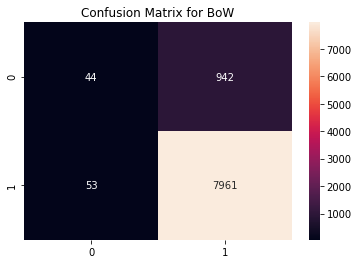

In [72]:
cm = confusion_matrix(Ytest,prediction)
sn.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

In [74]:
from sklearn.metrics import f1_score
F1=f1_score(Ytest,prediction)
print(F1)

0.9411834249571437


# K fold Cross Validation


 The optimal number of neighbors is 9.


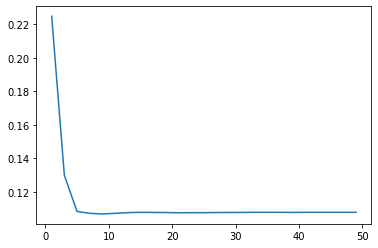

In [47]:
my=list(range(0,50))
ne=list(filter(lambda x:x %2 !=0, my))
cvscore=[]

for k in ne:
    knn= KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,XTrain,Ytrain, cv=10, scoring='accuracy')
    cvscore.append(scores.mean())
    
MSE= [1-x for x in cvscore]

optimalk=ne[MSE.index(min(MSE))]
print('\n The optimal number of neighbors is %d.' % optimalk)
plt.plot(ne,MSE)

In [59]:
knnopt=KNeighborsClassifier(n_neighbors=optimalk)
knnopt.fit(XTrain,Ytrain)
prediction=knnopt.predict(Xtest)
acc=accuracy_score(Ytest,prediction,normalize=True)*float(100)
print('\n CV accuracy for k= %d is %d%%' %(optimalk, acc))


 CV accuracy for k= 9 is 89%


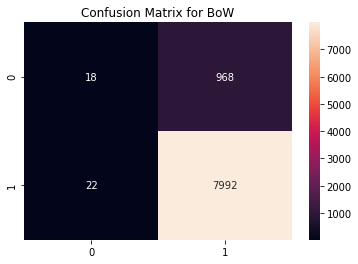

In [61]:
cm = confusion_matrix(Ytest,prediction)
sn.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for TF-IDF')
plt.show()

In [68]:
from sklearn.metrics import f1_score
F1=f1_score(Ytest,prediction)

In [69]:
F1

0.9411834249571437

# USING TF-IDF

In [75]:
tfidf=TfidfVectorizer(ngram_range=(1,2))
finaltfidf=tfidf.fit_transform(X)

In [76]:
X1,Xtest,Y1,Ytest=train_test_split(finaltfidf,Y,test_size=0.3,random_state=0)
XTrain,Xcv,Ytrain,Ycv=train_test_split(X1,Y1,test_size=0.3)

# Simple Cross Validation

In [77]:
for i in range(1,10,2):
    knn=KNeighborsClassifier(n_neighbors=i)
    knn.fit(XTrain,Ytrain)
    prediction=knn.predict(Xcv)
    acc=accuracy_score(Ycv,prediction,normalize=True)*float(100)
    print('\n CV accuracy for k= %d is %d%%' %(i,acc))
    


 CV accuracy for k= 1 is 86%

 CV accuracy for k= 3 is 89%

 CV accuracy for k= 5 is 90%

 CV accuracy for k= 7 is 90%

 CV accuracy for k= 9 is 90%


In [78]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(XTrain,Ytrain)
prediction=knn.predict(Xtest)
acc=accuracy_score(Ytest,prediction,normalize=True)*float(100)
print('\n CV accuracy for k= 5 is %d%%' %(acc))


 CV accuracy for k= 5 is 89%


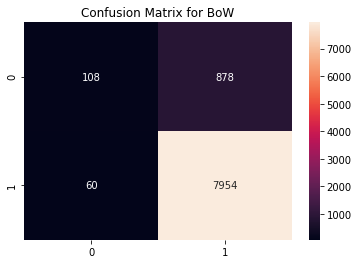

In [79]:
cm = confusion_matrix(Ytest,prediction)
sn.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

In [80]:
from sklearn.metrics import f1_score
F1=f1_score(Ytest,prediction)
print(F1)

0.9443191262020658


# K-Fold Cross Validation


 The optimal number of neighbors is 7.


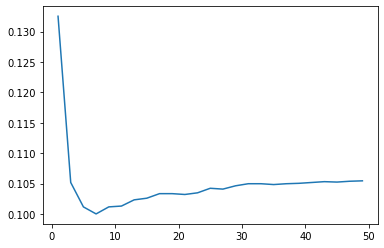

In [81]:
my=list(range(0,50))
ne=list(filter(lambda x:x %2 !=0, my))
cvscore=[]

for k in ne:
    knn= KNeighborsClassifier(n_neighbors=k)
    scores=cross_val_score(knn,XTrain,Ytrain, cv=10, scoring='accuracy')
    cvscore.append(scores.mean())
    
MSE= [1-x for x in cvscore]

optimalk=ne[MSE.index(min(MSE))]
print('\n The optimal number of neighbors is %d.' % optimalk)
plt.plot(ne,MSE)

In [82]:
knnopt=KNeighborsClassifier(n_neighbors=optimalk)
knnopt.fit(XTrain,Ytrain)
prediction=knnopt.predict(Xtest)
acc=accuracy_score(Ytest,prediction,normalize=True)*float(100)
print('\n CV accuracy for k= %d is %d%%' %(optimalk, acc))


 CV accuracy for k= 7 is 89%


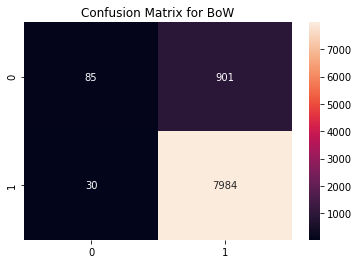

In [83]:
cm = confusion_matrix(Ytest,prediction)
sn.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

In [84]:
from sklearn.metrics import f1_score
F1=f1_score(Ytest,prediction)
print(F1)

0.9449079827208711
